In [38]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [39]:
df = pd.read_csv("./train.csv")

### Veo el score de todos los features que me permite usar el modelo sin modificar nada

In [40]:
#df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train.drop(['precio'],1)
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [41]:
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)
prediccion_anido = (prediccion + prediccion)/2

/home/giaco/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:10:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

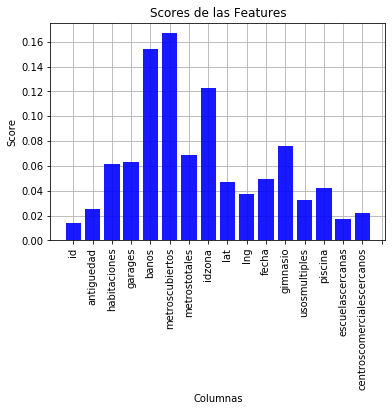

In [42]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [43]:
xgb_model.feature_importances_

array([0.01411386, 0.0256197 , 0.06148305, 0.06300923, 0.15394966,
       0.16678976, 0.06898949, 0.12251072, 0.04676291, 0.03718049,
       0.04909461, 0.07631807, 0.03272098, 0.04234249, 0.01733633,
       0.0217787 ], dtype=float32)

In [44]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  570781.1997218967


#### Podemos observar si obtenemos un mejor score con agregados que teniendo piscina, escuelas cercanas, usos multiples y
#### centros comerciales por separado, vamos a probar unificando esos features

In [46]:
df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion','escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train.drop(['precio'],1)
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/giaco/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:16:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

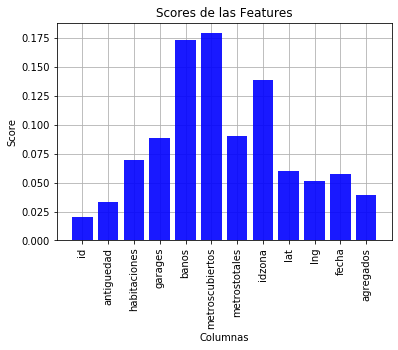

In [47]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [48]:
xgb_model.feature_importances_

array([0.02041972, 0.0335198 , 0.06983829, 0.08817904, 0.17364502,
       0.17898934, 0.08985296, 0.13872664, 0.05974402, 0.05126221,
       0.05698146, 0.03884152], dtype=float32)

In [49]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  622845.5635790202


# Funciones para usar mean encoding

In [50]:
def mean_target_encoding(train, nombrefeat, nombretarget):
        
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean) #Saco promedio
    temp = preprocessing.scale(temp) #Normalizo
    train[nombrefeat + "_mean"] = temp #Dejo en el DF
    
    return train

In [51]:
def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

# mean o features originales?

In [52]:
df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion','id'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

X_train = mean_target_encoding(X_train, "escuelascercanas", "precio")
X_test = mean_target_decoding(X_test, "escuelascercanas", X_train)


X_train = mean_target_encoding(X_train, "gimnasio", "precio")
X_test = mean_target_decoding(X_test, "gimnasio", X_train)

X_train = mean_target_encoding(X_train, "centroscomercialescercanos", "precio")
X_test = mean_target_decoding(X_test, "centroscomercialescercanos", X_train)

X_train = mean_target_encoding(X_train, "piscina", "precio")
X_test = mean_target_decoding(X_test, "piscina", X_train)

X_train = mean_target_encoding(X_train, "usosmultiples", "precio")
X_test = mean_target_decoding(X_test, "usosmultiples", X_train)

X_train = mean_target_encoding(X_train, "fecha", "precio")
X_test = mean_target_decoding(X_test, "fecha", X_train)

X_train = mean_target_encoding(X_train, "antiguedad", "precio")
X_test = mean_target_decoding(X_test, "antiguedad", X_train)

X_train = mean_target_encoding(X_train, "habitaciones", "precio")
X_test = mean_target_decoding(X_test, "habitaciones", X_train)

X_train = mean_target_encoding(X_train, "garages", "precio")
X_test = mean_target_decoding(X_test, "garages", X_train)

X_train = mean_target_encoding(X_train, "banos", "precio")
X_test = mean_target_decoding(X_test, "banos", X_train)

X_train = mean_target_encoding(X_train, "metroscubiertos", "precio")
X_test = mean_target_decoding(X_test, "metroscubiertos", X_train)

X_train = mean_target_encoding(X_train, "metrostotales", "precio")
X_test = mean_target_decoding(X_test, "metrostotales", X_train)

X_train = mean_target_encoding(X_train, "lat", "precio")
X_test = mean_target_decoding(X_test, "lat", X_train)

X_train = mean_target_encoding(X_train, "lng", "precio")
X_test = mean_target_decoding(X_test, "lng", X_train)

X_train = mean_target_encoding(X_train, "agregados", "precio")
X_test = mean_target_decoding(X_test, "agregados", X_train)

X_train = mean_target_encoding(X_train, "idzona", "precio")
X_test = mean_target_decoding(X_test, "idzona", X_train)



X_train = X_train.drop(['precio'],1) 
X_test = X_test.drop(['precio'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

[14:18:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

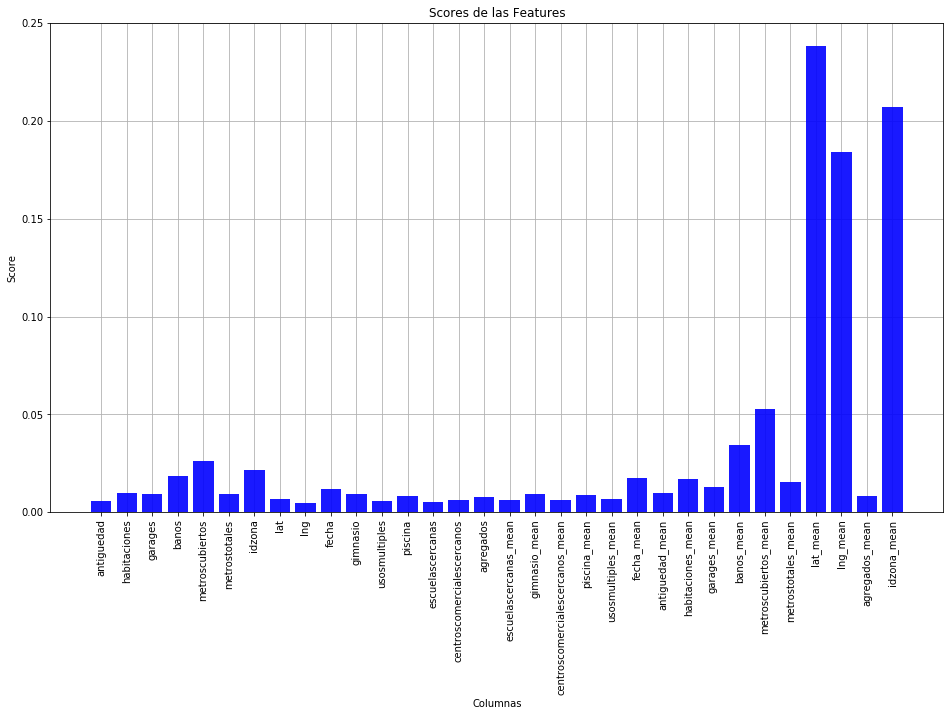

In [61]:
columnas = X_train.columns
k_utilizado = np.arange(32)
scores = xgb_model.feature_importances_
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [54]:
xgb_model.feature_importances_

array([0.00577707, 0.00968828, 0.00929714, 0.01857768, 0.02609542,
       0.0091793 , 0.0215943 , 0.00650369, 0.00487831, 0.01172061,
       0.00951386, 0.00596705, 0.00812387, 0.00505169, 0.00632899,
       0.00792582, 0.00611552, 0.00929695, 0.00637244, 0.00854981,
       0.00657244, 0.01755269, 0.00980944, 0.01698929, 0.01287762,
       0.0342675 , 0.05263046, 0.0155117 , 0.2381428 , 0.18400201,
       0.00820343, 0.2068828 ], dtype=float32)

In [62]:

print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  714451.3149066976


## Agregando la direccion 

### Tiene o no direccion

In [75]:
df['direccion'].value_counts()
df1=df

In [76]:
df1.loc[df['direccion'] == 'Calle', 'direccion'] = 0
df1.loc[df['direccion'] == '1', 'direccion'] = 0
df1.loc[df['direccion'] == '.', 'direccion'] = 0
df1.loc[df['direccion'] == '-', 'direccion'] = 0
df1.loc[df['direccion'] != 0, 'direccion'] = 1

In [77]:
df1['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df1.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.dropna()
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)

X_train = mean_target_encoding(X_train, "provincia", "precio")
X_test = mean_target_decoding(X_test, "provincia", X_train)

X_train = mean_target_encoding(X_train, "ciudad", "precio")
X_test = mean_target_decoding(X_test, "ciudad", X_train)

                               
                               
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)


/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

[14:38:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

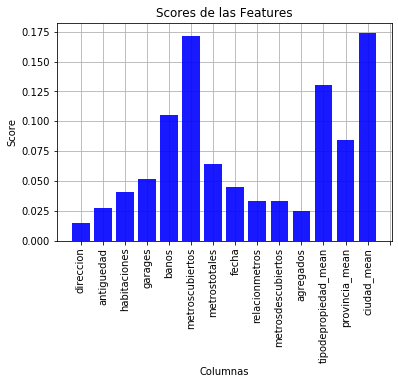

In [78]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [80]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  609413.083818929


### Pruebo usando mean encoding para direccion

In [88]:
df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.dropna()
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

#Preparo el train y test 
X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_train = mean_target_encoding(X_train, "provincia", "precio")
X_train = mean_target_encoding(X_train, "ciudad", "precio")
X_train = mean_target_encoding(X_train, "direccion", "precio") # no parece ser buena idea usar esto 
                                                #no deberia tener las mismas direcciones ente train y test

X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)
X_test = mean_target_decoding(X_test, "provincia", X_train)
X_test = mean_target_decoding(X_test, "ciudad", X_train)
X_test = mean_target_decoding(X_test, "direccion", X_train)
                               
                               
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/giaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

[15:11:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

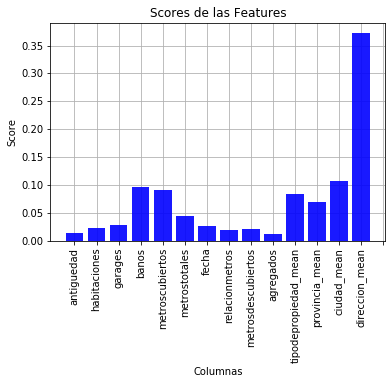

In [89]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [90]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  678483.3151480713


#### La importancia de la direccion fue 0.00072118 por lo que al menos de esta forma no es relevante para el modelo . En cambio si no uso lo antes mencionado y uso direccion mean el score de direccion pasa a ser 0.0006491 mas bajo de lo que era simplemente remplanzando por 0 si no era una direccion valida y por 1 si lo era.

# Buscar palabras clave en la descripcion y titulo

In [84]:
#Ver notebook correspondiente